# Network Initialization

In [ ]:
!pip install lark groq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from typing import Any, Callable, Literal
from datetime import datetime
from tqdm.auto import tqdm
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import roc_auc_score
from groq import Groq
import os
import shutil
import io
import re
import json
import base64
import random
import inspect
import time
import itertools
import lark
import torch
import torchsummary
import pandas as pd
import matplotlib.pyplot as plt

ROOT_DIR = os.getcwd()
DRIVE_DATASETS_DIR = os.path.join(ROOT_DIR, 'drive', 'MyDrive', 'Thesis', 'visudo_pc', 'datasets')
DRIVE_LOGS_DIR = os.path.join(ROOT_DIR, 'drive', 'MyDrive', 'Thesis', 'visudo_pc', 'logs')
DATASETS_DIR = os.path.join(ROOT_DIR, 'visudo_pc')
GROQ_API_KEY = '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'

In [ ]:
drive.mount('/content/drive')
if not os.path.exists(DATASETS_DIR):
    os.makedirs(DATASETS_DIR)
for file_name in os.listdir(DRIVE_DATASETS_DIR):
    if file_name.endswith('.pt'):
        file_path = os.path.join(DRIVE_DATASETS_DIR, file_name)
        shutil.copy(file_path, DATASETS_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LTN

## FOL Grammar

In [ ]:
CONSTANT_TERMINAL = 'constant'
VARIABLE_TERMINAL = 'variable'
FUNCTION_TERMINAL = 'function'
PREDICATE_TERMINAL = 'predicate'
WRAPPER_TERMINAL = 'wrapper'
LOGICAL_NOT_TERMINAL = 'logical_not'
LOGICAL_AND_TERMINAL = 'logical_and'
LOGICAL_OR_TERMINAL = 'logical_or'
IMPLIES_TERMINAL = 'implies'
IFF_TERMINAL = 'iff'
FORALL_TERMINAL = 'forall'
EXISTS_TERMINAL = 'exists'

CONSTANT_SYMBOL = 'C'
VARIABLE_SYMBOL = 'x'
FUNCTION_SYMBOL = 'f'
PREDICATE_SYMBOL = 'P'
WRAPPER_SYMBOL = ''
LOGICAL_NOT_SYMBOL = '!'
LOGICAL_AND_SYMBOL = '&'
LOGICAL_OR_SYMBOL = '|'
IMPLIES_SYMBOL = 'implies'
IFF_SYMBOL = 'iff'
FORALL_SYMBOL = 'forall'
EXISTS_SYMBOL = 'exists'

FOL_GRAMMAR = f'''
//// Explanations ////

    // {CONSTANT_TERMINAL} identifiers always start with "{CONSTANT_SYMBOL}"
    // {VARIABLE_TERMINAL} identifiers always start with "{VARIABLE_SYMBOL}"
    // {FUNCTION_TERMINAL} identifiers always start with "{FUNCTION_SYMBOL}"
    // {PREDICATE_TERMINAL} identifiers always start with "{PREDICATE_SYMBOL}"
    // wrapper symbol is "{WRAPPER_SYMBOL}(" and ")"
    // negation symbol is "{LOGICAL_NOT_SYMBOL}"
    // conjunction symbol is "{LOGICAL_AND_SYMBOL}"
    // disjunction symbol is "{LOGICAL_OR_SYMBOL}"
    // implication symbol is "{IMPLIES_SYMBOL}"
    // equivalence symbol is "{IFF_SYMBOL}"
    // universal quantifier symbol is "{FORALL_SYMBOL}"
    // existential quantifier symbol is "{EXISTS_SYMBOL}"

//// Initialization ////

    // imports
     %import common.WS
     %ignore WS

    // entry point
    ?start: expression

//// Term-Level Terminal Definitions  ////

    // Tree Structure:
    // term
    // ├─atom
    // │ └─{CONSTANT_TERMINAL}, {VARIABLE_TERMINAL}
    // └─mapper
    //   └─{FUNCTION_TERMINAL}

    // Abstract Terminal (no precedence)
    ?term: {CONSTANT_TERMINAL} | {VARIABLE_TERMINAL} | {FUNCTION_TERMINAL}

    // Concrete Terminals (no precedence)
    {CONSTANT_TERMINAL}: /{CONSTANT_SYMBOL}[a-z0-9_]*/
    {VARIABLE_TERMINAL}: /{VARIABLE_SYMBOL}[a-z0-9_]*/
    {FUNCTION_TERMINAL}: /{FUNCTION_SYMBOL}[a-z0-9_]*/ "(" term ("," term)* ")"

//// Expression-Level Terminal Definitions ////

    // Tree Structure:
    // expression
    // ├─evaluator
    // │ └─{PREDICATE_TERMINAL}
    // ├─unary_connective
    // │ └─{WRAPPER_TERMINAL}, {LOGICAL_NOT_TERMINAL}
    // ├─binary_connective
    // │ └─{LOGICAL_AND_TERMINAL}, {LOGICAL_OR_TERMINAL}, {IMPLIES_TERMINAL}, {IFF_TERMINAL}
    // └─quantifier
    //   └─{FORALL_TERMINAL}, {EXISTS_TERMINAL}

    // Abstract Terminal (ascending precedence)
    ?expression: level_0
    ?level_0: level_1 | {EXISTS_TERMINAL} | {FORALL_TERMINAL}
    ?level_1: level_2 | {IFF_TERMINAL} | {IMPLIES_TERMINAL}
    ?level_2: level_3 | {LOGICAL_OR_TERMINAL}
    ?level_3: level_4 | {LOGICAL_AND_TERMINAL}
    ?level_4: level_5 | {LOGICAL_NOT_TERMINAL} | {WRAPPER_TERMINAL}
    ?level_5: predicate

    // Concrete Terminals (ascending precedence)
    {PREDICATE_TERMINAL}: /{PREDICATE_SYMBOL}[a-z0-9_]*/ "(" term ("," term)* ")"
    {WRAPPER_TERMINAL}: "{WRAPPER_SYMBOL}(" expression ")"
    {LOGICAL_NOT_TERMINAL}: "{LOGICAL_NOT_SYMBOL}" level_4
    {LOGICAL_AND_TERMINAL}: level_4 "{LOGICAL_AND_SYMBOL}" level_3
    {LOGICAL_OR_TERMINAL}: level_2 "{LOGICAL_OR_SYMBOL}" level_3
    {IMPLIES_TERMINAL}: level_1 "{IMPLIES_SYMBOL}" level_2
    {IFF_TERMINAL}: level_1 "{IFF_SYMBOL}" level_2
    {FORALL_TERMINAL}: "{FORALL_SYMBOL}" {VARIABLE_TERMINAL} ("," {VARIABLE_TERMINAL})* expression
    {EXISTS_TERMINAL}: "{EXISTS_SYMBOL}" {VARIABLE_TERMINAL} ("," {VARIABLE_TERMINAL})* expression
'''

## Groundings

In [ ]:
class Grd():

    # Abstract Super Grounding
    class Base():
        def __init__(self, description:str, content:None|str|torch.Tensor|torch.nn.Module|Callable[..., torch.Tensor], hyper_arg_dict:dict[str, int|float]) -> None:
            self.description = description
            self.content = content
            self.hyper_arg_dict = hyper_arg_dict
        def __repr__(self) -> str:
            return self.__str__()
        def __str__(self) -> str:
            return self.description
        def __call__(self, *args:Any) -> Any:
            raise NotImplementedError()

    # Concrete Groundings
    class Empty(Base):
        def __init__(self) -> None:
            super().__init__('empty', None, {})
        def __call__(self) -> None:
            return self.content

    class Command(Base):
        def __init__(self, command:str) -> None:
            super().__init__('command', command, {})
        def __call__(self) -> str:
            return self.content

    class Value(Base):
        def __init__(self, tensor:torch.Tensor) -> None:
            shape = 'scalar' if tensor.ndim == 0 else f'{tensor.shape[0]}x0' if tensor.ndim == 1 else 'x'.join(str(dim) for dim in tensor.shape)
            trainability = 'trainable' if tensor.requires_grad else 'non-trainable'
            super().__init__(f'tensor[{shape}, {trainability}]', tensor, {})
        def __call__(self) -> torch.Tensor:
            return self.content

    class Network(Base):
        def __init__(self, network:torch.nn.Module) -> None:
            tot_params = sum(tensor.numel() for tensor in network.parameters())
            tot_trainable_params = sum(tensor.numel() for tensor in network.parameters() if tensor.requires_grad)
            super().__init__(f'network[{tot_params} params, {tot_trainable_params} trainable]', network, {})
        def __call__(self, *args:torch.Tensor) -> torch.Tensor:
            return self.content(*args)

    class Routine(Base):
        @classmethod
        def wrap(cls, description:str) -> Callable[[Callable[..., torch.Tensor]], 'Grd.Routine']:
            def decorator(routine: Callable[..., torch.Tensor]) -> Grd.Routine:
                return Grd.Routine(staticmethod(routine), description)
            return decorator
        def __init__(self, routine:Callable[..., torch.Tensor], description:str):
            signature = inspect.signature(routine).parameters
            assert all(arg_value.annotation is not inspect._empty for arg_value in signature.values()), "The routine must be type-hinted!"
            hyper_arg_dict = dict[str, int|float]()
            for arg_name, arg_value in signature.items():
                if arg_value.annotation in (int, float):
                    hyper_arg_dict[arg_name] = arg_value.default if arg_value.default is not inspect._empty else None
            if len(hyper_arg_dict) > 0:
                hyper_arg = f', {len(hyper_arg_dict)} hyper-arg' + ('s' if len(hyper_arg_dict) > 1 else '') + f', {sum(hyper_arg_value is None for hyper_arg_value in hyper_arg_dict.values())} empty'
            else:
                hyper_arg = ''
            super().__init__(f'{routine.__name__}[{description}{hyper_arg}]', routine, hyper_arg_dict)
        def __call__(self, *args:torch.Tensor) -> torch.Tensor:
            return self.content(*args, **self.hyper_arg_dict)

## Blocks

In [ ]:
class Blk():

    # Abstract Super Block
    class Base():
        PRINT_PRIORITY = 0
        TERMINAL:str|None = None
        def __init__(self, name:str, symbol:str, *children:'Blk.Base') -> None:
            self.name = name
            self.symbol = symbol
            self.children = children
            self.current_grd:Grd.Base = Grd.Empty()
            self.default_grd_dict = {k: v for k, v in self.__class__.__dict__.items() if isinstance(v, Grd.Routine)}
            self.global_blk_list = list['Blk.Base']()
            self.global_domain_list = list[str]()
            self.involved_domain_set = set[str]()
            self.arg_shape_dict = dict[str, list[str]]()
            self.inp_shape_list = list[str]()
            self.out_shape_list = list[str]()
        def __repr__(self) -> str:
            return self.__str__()
        def __str__(self) -> str:
            raise NotImplementedError()
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            raise NotImplementedError()
        def setup_blks(self, global_blk_list:list['Blk.Base']) -> None:
            for child in self.children:
                child.setup_blks(global_blk_list)
            global_blk_list.append(self)
            self.global_blk_list = global_blk_list
        def setup_domains(self, global_domain_list:list[str]) -> None:
            for child in self.children:
                child.setup_domains(global_domain_list)
            if isinstance(self, Blk.Quantifier):
                for variable in self.children[:-1]:
                    if variable.name not in global_domain_list:
                        global_domain_list.append(variable.name)
            global_domain_list.sort()
            self.global_domain_list = global_domain_list
        def setup_shapes(self) -> None:
            for child in self.children:
                child.setup_shapes()
            if isinstance(self, Blk.Atom):
                self.out_shape_list.append('B*')
                if self.name in self.global_domain_list:
                    self.involved_domain_set = {self.name}
                    self.out_shape_list.append(f'D{self.name}')
                self.out_shape_list.append(f'E{self.name}')
            elif isinstance(self, Blk.Mapper):
                for term in self.children:
                    self.involved_domain_set.update(term.involved_domain_set)
                    self.arg_shape_dict[term.name] = term.out_shape_list
                self.out_shape_list.append('B*')
                for domain in self.global_domain_list:
                    self.out_shape_list.append(f'D{domain}' if domain in self.involved_domain_set else '1')
                self.out_shape_list.append(f'E{self.name}')
            elif isinstance(self, Blk.BinaryConnective):
                left, right = self.children
                self.involved_domain_set.update(left.involved_domain_set)
                self.involved_domain_set.update(right.involved_domain_set)
                self.arg_shape_dict['left_tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.arg_shape_dict['right_tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.out_shape_list = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
            elif isinstance(self, Blk.UnaryConnective):
                body = self.children[0]
                self.involved_domain_set.update(body.involved_domain_set)
                self.arg_shape_dict['tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.out_shape_list = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
            elif isinstance(self, Blk.Quantifier):
                body = self.children[-1]
                self.involved_domain_set.update(self.global_domain_list)
                for variable in self.children[:-1]:
                    self.involved_domain_set.remove(variable.name)
                self.arg_shape_dict['tensor'] = ['B*'] + [f'D{domain}*' for domain in self.global_domain_list]
                self.out_shape_list = ['B*'] + [f'D{domain}**' for domain in self.global_domain_list]
            elif isinstance(self, Blk.Evaluator):
                for term in self.children:
                    self.involved_domain_set.update(term.involved_domain_set)
                    self.arg_shape_dict[term.name] = term.out_shape_list
                self.out_shape_list.append('B*')
                for domain in self.global_domain_list:
                    self.out_shape_list.append(f'D{domain}' if domain in self.involved_domain_set else '1')
        def ground(self, **context_dict:Grd.Command|Grd.Value|Grd.Network|Grd.Routine) -> None:
            if self.name in context_dict:
                temporary_ground = context_dict[self.name]
                if isinstance(temporary_ground, Grd.Command):
                    self.current_grd = self.default_grd_dict[temporary_ground()]
                else:
                    self.current_grd = temporary_ground
            for child in self.children:
                child.ground(**context_dict)
        def schedule(self, **hyper_arg_dict:dict[str, int|float]) -> None:
            if self.name in hyper_arg_dict:
                for arg_name, arg_value in hyper_arg_dict[self.name].items():
                    if arg_name in self.current_grd.hyper_arg_dict:
                        self.current_grd.hyper_arg_dict[arg_name] = arg_value
            for child in self.children:
                child.schedule(**hyper_arg_dict)

    # Abstract High-Level Blocks
    class Term(Base):
        def __init__(self, name:str, symbol:str, *children:'Blk.Base') -> None:
            super().__init__(name, symbol, *children)

    class Expression(Base):
        def __init__(self, name:str, symbol:str, *children:'Blk.Base') -> None:
            super().__init__(name, symbol, *children)

    # Abstract Medium-Level Blocks
    class Atom(Term):
        PRINT_PRIORITY = 1
        def __init__(self, name:str, symbol:str) -> None:
            super().__init__(name, symbol)
            self.current_grd:Grd.Empty|Grd.Value = Grd.Empty()
        def __str__(self) -> str:
            return self.name
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            if isinstance(self.current_grd, Grd.Empty):
                return value_dict[self.name]
            return self.current_grd()

    class Mapper(Term):
        PRINT_PRIORITY = 2
        def __init__(self, name:str, symbol:str, *terms:'Blk.Term') -> None:
            super().__init__(name, symbol, *terms)
            self.current_grd:Grd.Empty|Grd.Network|Grd.Routine = Grd.Empty()
        def __str__(self) -> str:
            return self.name + '(' + ', '.join(str(child) for child in self.children) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            return self.current_grd(*[term(**value_dict) for term in self.children])

    class Evaluator(Expression):
        PRINT_PRIORITY = 3
        def __init__(self, name:str, symbol:str, *terms:'Blk.Term') -> None:
            super().__init__(name, symbol, *terms)
            self.current_grd:Grd.Empty|Grd.Network|Grd.Routine = Grd.Empty()
        def __str__(self) -> str:
            return self.name + '(' + ', '.join(str(child) for child in self.children) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            return self.current_grd(*[term(**value_dict) for term in self.children])

    class UnaryConnective(Expression):
        PRINT_PRIORITY = 4
        def __init__(self, name:str, symbol:str, default_grd:Grd.Routine, body:'Blk.Expression') -> None:
            super().__init__(name, symbol, body)
            self.current_grd = default_grd
        def __str__(self) -> str:
            return self.symbol + '(' + str(self.children[0]) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            body = self.children[0]
            return self.current_grd(body(**value_dict))

    class BinaryConnective(Expression):
        PRINT_PRIORITY = 5
        def __init__(self, name:str, symbol:str, default_grd:Grd.Routine, left:'Blk.Expression', right:'Blk.Expression') -> None:
            super().__init__(name, symbol, left, right)
            self.current_grd = default_grd
        def __str__(self) -> str:
            return str(self.children[0]) + ' ' + self.symbol + ' ' + str(self.children[1])
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            left, right = self.children
            return self.current_grd(left(**value_dict), right(**value_dict))

    class Quantifier(Expression):
        PRINT_PRIORITY = 6
        def __init__(self, name:str, symbol:str, default_grd:Grd.Routine, body:'Blk.Expression', *variables:'Blk.Variable') -> None:
            super().__init__(name, symbol, *variables, body)
            self.current_grd = default_grd
        def __str__(self) -> str:
            return self.symbol + '[' + ', '.join(str(child) for child in self.children[:-1]) + '](' + str(self.children[-1]) + ')'
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            variable_list = self.children[:-1]
            body = self.children[-1]
            reduction_dim_list = [self.global_domain_list.index(variable.name) + 1 for variable in variable_list]
            return self.current_grd(reduction_dim_list, body(**value_dict))

    # Concrete Blocks
    class Constant(Atom):
        TERMINAL = CONSTANT_TERMINAL
        def __init__(self, in_list:list[lark.Token]) -> None:
            super().__init__(in_list[0].value, CONSTANT_SYMBOL)

    class Variable(Atom):
        TERMINAL = VARIABLE_TERMINAL
        def __init__(self, in_list:list[lark.Token]) -> None:
            super().__init__(in_list[0].value, VARIABLE_SYMBOL)

    class Function(Mapper):
        TERMINAL = FUNCTION_TERMINAL
        def __init__(self, in_list:list['lark.Token|Blk.Term']) -> None:
            super().__init__(in_list[0].value, FUNCTION_SYMBOL, *in_list[1:])

    class Predicate(Evaluator):
        TERMINAL = PREDICATE_TERMINAL
        def __init__(self, in_list:list['lark.Token|Blk.Term']) -> None:
            super().__init__(in_list[0].value, PREDICATE_SYMBOL, *in_list[1:])

    class Wrapper(UnaryConnective):
        TERMINAL = WRAPPER_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(WRAPPER_TERMINAL, WRAPPER_SYMBOL, self.identity, in_list[0])
        @Grd.Routine.wrap('x')
        def identity(tensor:torch.Tensor) -> torch.Tensor:
            return tensor

    class LogicalNot(UnaryConnective):
        TERMINAL = LOGICAL_NOT_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(LOGICAL_NOT_TERMINAL, LOGICAL_NOT_SYMBOL, self.complementation, in_list[0])
        @Grd.Routine.wrap('1 - x')
        def complementation(tensor:torch.Tensor) -> torch.Tensor:
            return 1.0 - tensor

    class LogicalAnd(BinaryConnective):
        TERMINAL = LOGICAL_AND_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(LOGICAL_AND_TERMINAL, LOGICAL_AND_SYMBOL, self.lukasiewicz, in_list[0], in_list[1])
        @Grd.Routine.wrap('max(0, x1 + x2 - 1)')
        def lukasiewicz(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.maximum(torch.tensor(0.0, device=left_tensor.device), left_tensor + right_tensor - 1.0)
        @Grd.Routine.wrap('min(x1, x2)')
        def godel(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.minimum(left_tensor, right_tensor)
        @Grd.Routine.wrap('x1 * x2')
        def goguen(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return left_tensor * right_tensor

    class LogicalOr(BinaryConnective):
        TERMINAL = LOGICAL_OR_TERMINAL
        def __init__(self, in_list:list[Any]) -> None:
            super().__init__(LOGICAL_OR_TERMINAL, LOGICAL_OR_SYMBOL, self.lukasiewicz, in_list[0], in_list[1])
        @Grd.Routine.wrap('min(1, x1 + x2)')
        def lukasiewicz(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.minimum(torch.tensor(1.0, device=left_tensor.device), left_tensor + right_tensor)
        @Grd.Routine.wrap('max(x1, x2)')
        def godel(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.maximum(left_tensor, right_tensor)
        @Grd.Routine.wrap('1 - (1 - x1) * (1 - x2)')
        def goguen(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return 1.0 - (1.0 - left_tensor) * (1.0 - right_tensor)

    class Implies(BinaryConnective):
        TERMINAL = IMPLIES_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(IMPLIES_TERMINAL, IMPLIES_SYMBOL, self.lukasiewicz, in_list[0], in_list[1])
        @Grd.Routine.wrap('min(1, 1 - x1 + x2)')
        def lukasiewicz(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.minimum(torch.tensor(1.0, device=left_tensor.device), 1 - left_tensor + right_tensor)
        @Grd.Routine.wrap('1 if x1 <= x2 else x2')
        def godel(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.where(left_tensor <= right_tensor, torch.tensor(1.0, device=left_tensor.device), right_tensor)
        @Grd.Routine.wrap('1 if x1 <=x2 else x2 / x1')
        def goguen(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.where(left_tensor <= right_tensor, torch.tensor(1.0, device=left_tensor.device), right_tensor / torch.clamp(left_tensor, min=1e-6))
        @Grd.Routine.wrap('max(1 - x1, x2)')
        def kleene_dienes(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return torch.maximum(1 - left_tensor, right_tensor)
        @Grd.Routine.wrap('1 - x1 + x1 * x2')
        def reichenbach(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return 1.0 - left_tensor + left_tensor * right_tensor

    class Iff(BinaryConnective):
        TERMINAL = IFF_TERMINAL
        def __init__(self, in_list:list['Blk.Expression']) -> None:
            super().__init__(IFF_TERMINAL, IFF_SYMBOL, self.linear_similarity, in_list[0], in_list[1])
        @Grd.Routine.wrap('1 - |x1 - x2|')
        def linear_similarity(left_tensor:torch.Tensor, right_tensor:torch.Tensor) -> torch.Tensor:
            return 1.0 - torch.abs(left_tensor - right_tensor)

    class ForAll(Quantifier):
        TERMINAL = FORALL_TERMINAL
        def __init__(self, in_list:list['Blk.Variable|Blk.Expression']) -> None:
            super().__init__(FORALL_TERMINAL, FORALL_SYMBOL, self.lukasiewicz, in_list[-1], *in_list[:-1])
        @Grd.Routine.wrap('max(0, sum(xi) - n + 1)')
        def lukasiewicz(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            sum_tensor = torch.sum(tensor, dim=reduction_dim_list, keepdim=True)
            n = torch.prod(torch.tensor([tensor.size(dim) for dim in reduction_dim_list], device=tensor.device))
            return torch.maximum(torch.tensor(0.0, device=tensor.device), sum_tensor - n + 1)
        @Grd.Routine.wrap('min(xi)')
        def godel(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            return torch.amin(tensor, dim=reduction_dim_list, keepdim=True)
        @Grd.Routine.wrap('prod(xi)')
        def goguen(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            prod_tensor = tensor
            for dim in sorted(reduction_dim_list, reverse=True):
                prod_tensor = torch.prod(prod_tensor, dim=dim, keepdim=True)
            return prod_tensor
        @Grd.Routine.wrap('1 - mean((1 - xi) ** p) ** (1 / p)')
        def power_mean(reduction_dim_list:list[int], tensor:torch.Tensor, eps:float=0.1, p:int=2) -> torch.Tensor:
            return 1.0 - torch.mean((1.0 - (1 - eps) * tensor) ** p, dim=reduction_dim_list, keepdim=True) ** (1 / p)

    class Exists(Quantifier):
        TERMINAL = EXISTS_TERMINAL
        def __init__(self, in_list:list['Blk.Variable|Blk.Expression']) -> None:
            super().__init__(EXISTS_TERMINAL, EXISTS_SYMBOL, self.lukasiewicz, in_list[-1], *in_list[:-1])
        @Grd.Routine.wrap('min(1, sum(xi))')
        def lukasiewicz(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            sum_tensor = torch.sum(tensor, dim=reduction_dim_list, keepdim=True)
            return torch.minimum(torch.tensor(1.0, device=tensor.device), sum_tensor)
        @Grd.Routine.wrap('max(xi)')
        def godel(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            return torch.amax(tensor, dim=reduction_dim_list, keepdim=True)
        @Grd.Routine.wrap('1 - prod(1 - xi)')
        def goguen(reduction_dim_list:list[int], tensor:torch.Tensor) -> torch.Tensor:
            prod_tensor = 1.0 - tensor
            for dim in sorted(reduction_dim_list, reverse=True):
                prod_tensor = torch.prod(prod_tensor, dim=dim, keepdim=True)
            return 1.0 - prod_tensor
        @Grd.Routine.wrap('mean(xi ** p) ** (1 / p)')
        def power_mean(reduction_dim_list:list[int], tensor:torch.Tensor, eps:float=0.1, p:int=1) -> torch.Tensor:
            return torch.mean(((1 - eps) *tensor + eps) ** p, dim=reduction_dim_list, keepdim=True) ** (1 / p)

## Builder

In [ ]:
class LTNBuilder():

    # Explicit Formula
    class Formula():
        def __init__(self, fol_rule:str, fol_tree:lark.Tree, ltn_expression:'Blk.Expression') -> None:
            self._fol_rule = fol_rule
            self._fol_tree = fol_tree
            self._ltn_expression = ltn_expression
        def __call__(self, **value_dict:torch.Tensor) -> torch.Tensor:
            output = self._ltn_expression(**value_dict).squeeze()
            if output.ndim == 0:
                output = output.unsqueeze(0)
            return output
        def get_parameters(self) -> list[torch.nn.Parameter]:
            parameter_list = list[torch.nn.Parameter]()
            for blk in self._ltn_expression.global_blk_list:
                if isinstance(blk.current_grd, Grd.Value):
                    parameter_list.append(blk.current_grd.content)
                elif isinstance(blk.current_grd, Grd.Network):
                    parameter_list += list(blk.current_grd.content.parameters())
            return parameter_list
        def set_config(self, mode:Literal['device', 'status'], param:str) -> None:
            if mode == 'device':
                for blk in self._ltn_expression.global_blk_list:
                    if isinstance(blk.current_grd, Grd.Value):
                        blk.current_grd.content = blk.current_grd.content.to(param)
                    elif isinstance(blk.current_grd, Grd.Network):
                        blk.current_grd.content = blk.current_grd.content.to(param)
            elif mode == 'status':
                if param == 'train':
                    for blk in self._ltn_expression.global_blk_list:
                        if isinstance(blk.current_grd, Grd.Value):
                            blk.current_grd.content.requires_grad = True
                        elif isinstance(blk.current_grd, Grd.Network):
                            blk.current_grd.content.train()
                elif param == 'eval':
                    for blk in self._ltn_expression.global_blk_list:
                        if isinstance(blk.current_grd, Grd.Value):
                            blk.current_grd.content.requires_grad = False
                        elif isinstance(blk.current_grd, Grd.Network):
                            blk.current_grd.content.eval()
        def ground(self, **raw_context_dict:str|torch.Tensor|torch.nn.Module|Callable[..., torch.Tensor]) -> None:
            context_dict = dict[str, Grd.Command|Grd.Value|Grd.Network|Grd.Routine]()
            for blk_name in raw_context_dict:
                if isinstance(raw_context_dict[blk_name], str):
                    context_dict[blk_name] = Grd.Command(raw_context_dict[blk_name])
                elif isinstance(raw_context_dict[blk_name], torch.Tensor):
                    context_dict[blk_name] = Grd.Value(raw_context_dict[blk_name])
                elif isinstance(raw_context_dict[blk_name], torch.nn.Module):
                    context_dict[blk_name] = Grd.Network(raw_context_dict[blk_name])
                elif isinstance(raw_context_dict[blk_name], Callable):
                    context_dict[blk_name] = Grd.Routine(raw_context_dict[blk_name], 'n/a')
            self._ltn_expression.ground(**context_dict)
        def schedule(self, **hyper_arg_dict:dict[str, int|float]) -> None:
            self._ltn_expression.schedule(**hyper_arg_dict)
        def get(self, mode:Literal['raw', 'parsed', 'tree', 'info']) -> str:
            output = None
            if mode == 'raw':
                output = self._fol_rule
            elif mode == 'parsed':
                output = self._ltn_expression
            elif mode == 'tree':
                output = self._fol_tree.pretty()[:-1]
            elif mode == 'info':
                ungrounded_blk_dict = dict[tuple[int, str], str]()
                grounded_blk_dict = dict[tuple[int, str], str]()
                for blk in self._ltn_expression.global_blk_list:
                    if isinstance(blk.current_grd, Grd.Empty):
                        ungrounded_blk_dict[blk.PRINT_PRIORITY, blk.name] = f'  {blk.name} -> {blk.TERMINAL}'
                    else:
                        grounded_blk_dict[blk.PRINT_PRIORITY, blk.name] = f'  {blk.name} -> {blk.current_grd}'
                        if len(blk.default_grd_dict) > 0:
                            grounded_blk_dict[blk.PRINT_PRIORITY, blk.name] += '*, ' + ', '.join(str(grd) for grd in blk.default_grd_dict.values() if grd != blk.current_grd)
                ungrounded_blk_dict = dict(sorted(ungrounded_blk_dict.items(), key=lambda item: item[0]))
                grounded_blk_dict = dict(sorted(grounded_blk_dict.items(), key=lambda item: item[0]))
                output = ''
                if len(ungrounded_blk_dict) > 0:
                    output += '\nUngrounded Symbols:\n' + '\n'.join(ungrounded_blk_dict.values())
                if len(grounded_blk_dict) > 0:
                    output += '\nGrounded Symbols:\n' + '\n'.join(grounded_blk_dict.values())
                output = output[1:] if output.startswith('\n') else output
                output += (
                    '\nFootnotes:'
                    '\n  * -> current grounding'
                )
            elif mode == 'shapes':
                blk_dict = dict[tuple[int, str], str]()
                for blk in self._ltn_expression.global_blk_list:
                    shapes = list[str]()
                    if len(blk.arg_shape_dict) > 0:
                        argument_shape_list = list[str]()
                        for arg in blk.arg_shape_dict:
                            argument_shape_list.append(f'{arg}[' + ', '.join(blk.arg_shape_dict[arg]) + ']')
                        shapes.append('  inp shape -> ' + ', '.join(argument_shape_list))
                    if len(blk.inp_shape_list) > 0:
                        shapes.append('  inp shape -> ' + ', '.join(blk.inp_shape_list))
                    if len(blk.out_shape_list) > 0:
                        shapes.append('  out shape -> ' + ', '.join(blk.out_shape_list))
                    blk_dict[blk.PRINT_PRIORITY, blk.name] = '\n'.join(shapes)
                blk_dict = dict(sorted(blk_dict.items(), key=lambda item: item[0]))
                output = '\n'.join(f'{blk_name}:\n{blk_shapes}' for (_, blk_name), blk_shapes in blk_dict.items())
                output += (
                    '\nFootnotes:'
                    '\n  B -> batch size'
                    '\n  Dx -> domain size of `x`'
                    '\n  Ex -> extra dimensions of `x`'
                    '\n  * -> the dimension can also be equal to `1` but not missing'
                    '\n  ** -> the dimension is equal to `1` if its corresponding variable is involved in the quantifier'
                )
            return output

    def __init__(self, fol_grammar=FOL_GRAMMAR) -> None:
        self._fol_parser = lark.Lark(fol_grammar)
        self._fol_transformer = lark.Transformer()
        for Block in Blk.__dict__.values():
            if isinstance(Block, type) and issubclass(Block, Blk.Base) and Block.TERMINAL is not None:
                setattr(self._fol_transformer, Block.TERMINAL, Block)

    def make_formula(self, fol_rule:str) -> Formula:
        fol_tree = self._fol_parser.parse(fol_rule)
        ltn_expression:Blk.Expression = self._fol_transformer.transform(fol_tree)
        ltn_expression.setup_blks(list['Blk.Base']())
        ltn_expression.setup_domains(list[str]())
        ltn_expression.setup_shapes()
        ltn_formula = LTNBuilder.Formula(fol_rule, fol_tree, ltn_expression)
        return ltn_formula

# Platform

## Groundings Tools

In [ ]:
class SudokuNet(torch.nn.Module):

    def __init__(self, device:str, symbol_size:int, board_dim:int, drop_prob:float, use_softmax:bool):

        # Initialization
        super().__init__()
        self.device = device
        self.symbol_size = symbol_size
        self.board_dim = board_dim
        self.drop_prob = drop_prob
        self.use_softmax = use_softmax

        # CNN
        cnn_list = [
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=10,  out_channels=20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout2d(p=drop_prob)
        ]
        self.cnn = torch.nn.Sequential(*cnn_list)

        # Embedder
        embed_list = [
            torch.nn.Linear(in_features=320, out_features=50),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=drop_prob),
            torch.nn.Linear(in_features=50, out_features=board_dim)
        ]
        embed_list += [torch.nn.Softmax(dim=-1)] if use_softmax else []
        self.embed = torch.nn.Sequential(*embed_list)

        # Device Management
        self.to(device)

    def forward(self, symbols:torch.Tensor) -> torch.Tensor:
        '''
        inputs:
            symbols: Tensor[batch_size, board_dim, board_dim, symbol_size, symbol_size][cpu][torch.uint8]
        outputs:
            embeds: Tensor[batch_size, board_dim**2, last_embed_dim][device][torch.float32]
            indices: Tensor[batch_size, board_dim**2, 2][device][torch.float32]
        '''

        # Preparation
        batch_size = symbols.shape[0]
        symbols = symbols.to(self.device).to(torch.float32) / 255 # Tensor[batch_size, board_dim**2, symbol_size, symbol_size][device][torch.float32]
        symbols = symbols.view(-1, 1, self.symbol_size, self.symbol_size) # Tensor[batch_size*board_dim**2, 1, symbol_size, symbol_size][device][torch.float32]

        ## Visual Features
        features = self.cnn(symbols) # Tensor[batch_size*board_dim**2, 20, 4, 4][device][torch.float32]
        features = features.view(-1, 320) # Tensor[batch_size*board_dim**2, 320][device][torch.float32]

        # Embeddings
        embeds = self.embed(features) # Tensor[batch_size*board_dim**2, board_dim][device][torch.float32]
        embeds = embeds.view(batch_size, self.board_dim ** 2, -1) # Tensor[batch_size, board_dim**2, board_dim][device][torch.float32]

        # Indices
        indices = torch.cartesian_prod(torch.arange(self.board_dim), torch.arange(self.board_dim)) # Tensor[board_dim, board_dim][cpu][torch.int64]
        indices = indices.expand(batch_size, -1, 2) # Tensor[batch_size, board_dim**2, 2][cpu][torch.int64]
        indices = indices.to(self.device).to(torch.float32) # Tensor[batch_size, board_dim**2, 2][device][torch.float32]

        # Output
        return embeds, indices

In [ ]:
class EncoderNet(torch.nn.Module):

    def __init__(self, device:str, symbol_size:int, board_dim:int, cnn_dims:tuple[int, ...], kernel_dims:tuple[int, ...], embed_dims:tuple[int, ...], drop_prob:float, use_softmax:bool) -> None:

        # Initialization
        super().__init__()
        self.device = device
        self.symbol_size = symbol_size
        self.board_dim = board_dim
        self.cnn_dims = cnn_dims
        self.kernel_dims = kernel_dims
        self.embed_dims = embed_dims
        self.drop_prob = drop_prob
        self.use_softmax = use_softmax

        # CNN
        cnn_list = torch.nn.ModuleList()
        last_cnn_dim = 1
        pooled_symbol_size = symbol_size
        for cnn_dim, kernel_dim in zip(cnn_dims, kernel_dims):
            cnn_list.append(torch.nn.Conv2d(in_channels=last_cnn_dim, out_channels=cnn_dim, kernel_size=kernel_dim))
            cnn_list.append(torch.nn.ReLU())
            cnn_list.append(torch.nn.GroupNorm(num_groups=2, num_channels=cnn_dim))
            cnn_list.append(torch.nn.MaxPool2d(kernel_size=2))
            last_cnn_dim = cnn_dim
            pooled_symbol_size = (pooled_symbol_size - kernel_dim + 1) // 2
        cnn_list += [torch.nn.Dropout2d(p=drop_prob)]
        self.cnn = torch.nn.Sequential(*cnn_list)

        # Embedder
        embed_list = torch.nn.ModuleList()
        last_embed_dim = last_cnn_dim * pooled_symbol_size * pooled_symbol_size
        for i, embed_dim in enumerate(embed_dims):
            embed_list.append(torch.nn.Linear(in_features=last_embed_dim, out_features=embed_dim))
            embed_list.append(torch.nn.ReLU())
            embed_list.append(torch.nn.Dropout(p=drop_prob))
            last_embed_dim = embed_dim
        embed_list = embed_list[:-2] + ([torch.nn.Softmax(dim=-1)] if use_softmax else [])
        self.embed = torch.nn.Sequential(*embed_list)

        # Device Management
        self.to(device)

    def forward(self, symbols:torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        inputs:
            symbols: Tensor[batch_size, board_dim, board_dim, symbol_size, symbol_size][cpu][torch.uint8]
        outputs:
            embeds: Tensor[batch_size, board_dim**2, last_embed_dim][device][torch.float32]
            indices: Tensor[batch_size, board_dim**2, 2][device][torch.float32]
        '''

        # Preparation
        batch_size = symbols.shape[0]
        symbols = symbols.to(self.device).to(torch.float32) / 255 # Tensor[batch_size, board_dim**2, symbol_size, symbol_size][device][torch.float32]
        symbols = symbols.view(-1, 1, self.symbol_size, self.symbol_size) # Tensor[batch_size*board_dim**2, 1, symbol_size, symbol_size][device][torch.float32]

        # Visual Features
        features = self.cnn(symbols) # Tensor[batch_size*board_dim**2, last_cnn_dim, pooled_symbol_size, pooled_symbol_size][device][torch.float32]
        features = features.view(batch_size, self.board_dim ** 2, -1) # Tensor[batch_size, board_dim**2, last_cnn_dim*pooled_symbol_size*pooled_symbol_size][device][torch.float32]

        # Embeddings
        embeds = self.embed(features) # Tensor[batch_size, board_dim**2, last_embed_dim][device][torch.float32]

        # Indices
        indices = torch.cartesian_prod(torch.arange(self.board_dim), torch.arange(self.board_dim)) # Tensor[board_dim, board_dim][cpu][torch.int64]
        indices = indices.expand(batch_size, -1, 2) # Tensor[batch_size, board_dim**2, 2][cpu][torch.int64]
        indices = indices.to(self.device).to(torch.float32) # Tensor[batch_size, board_dim**2, 2][device][torch.float32]

        # Ouput
        return embeds, indices

In [ ]:
def binary_similarity(left_tensor:torch.Tensor, right_tensor:torch.Tensor, eps:float=0.1) -> torch.Tensor:
    '''
    inputs:
        left_tensor: Tensor[B, Dl, E][device][torch.float]
        right_tensor: Tensor[B, Dr, E][device][torch.float]
    outputs:
        output: Tensor[B, Dl, Dr][device][torch.float]
    footnotes:
        B: batch size, i.e, `batch_size`
        Dl: domain size of `left_tensor`
        Dr: domain size of `right_tensor`
        E: extra dimension of the tensors
    '''
    left_tensor = left_tensor.unsqueeze(2) # Tensor[B, Dl, 1, E][device][torch.float32]
    right_tensor = right_tensor.unsqueeze(1) # Tensor[B, 1, Dr, E][device][torch.float32]
    similarity = (left_tensor - right_tensor).abs().sum(dim=-1) # Tensor[B, Dl, Dr][device][torch.float32]
    similarity = torch.where(similarity > 0.0, torch.zeros_like(similarity) + eps, torch.ones_like(similarity) - eps) # Tensor[B, Dl, Dr][device][torch.float32]
    return similarity

def jaccard_similarity(left_tensor:torch.Tensor, right_tensor:torch.Tensor, eps:float=0.1, p:int=2) -> torch.Tensor:
    '''
    inputs:
        left_tensor: Tensor[B, Dl, E][device][torch.float]
        right_tensor: Tensor[B, Dr, E][device][torch.float]
        exp: exponentiation power
        eps: stability parameter
    outputs:
        output: Tensor[B, Dl, Dr][device][torch.float]
    footnotes:
        B: batch size, i.e, `batch_size`
        Dl: domain size of `left_tensor`
        Dr: domain size of `right_tensor`
        E: extra dimension of the tensors
    '''
    left_tensor = left_tensor.unsqueeze(2) # Tensor[B, Dl, 1, E][device][torch.float32]
    right_tensor = right_tensor.unsqueeze(1) # Tensor[B, 1, Dr, E][device][torch.float32]
    left_norm = (left_tensor * left_tensor).sum(dim=-1) # Tensor[B, Dl, 1][device][torch.float32]
    right_norm = (right_tensor * right_tensor).sum(dim=-1) # Tensor[B, 1, Dr][device][torch.float32]
    dot_product = (left_tensor * right_tensor).sum(dim=-1) # Tensor[B, Dl, Dr][device][torch.float32]
    similarity = 2 * dot_product / (left_norm + right_norm + eps) # Tensor[B, Dl, Dr][device][torch.float32]
    similarity = torch.where((left_norm < eps) & (right_norm < eps), torch.ones_like(similarity), similarity) # Tensor[B, Dl, Dr][device][torch.float32]
    return similarity ** p

def exponential_similarity(left_tensor:torch.Tensor, right_tensor:torch.Tensor, eps:float=0.1, p:int=2) -> torch.Tensor:
    '''
    inputs:
        left_tensor: Tensor[B, Dl, E][device][torch.float]
        right_tensor: Tensor[B, Dr, E][device][torch.float]
        k: norm order
    outputs:
        output: Tensor[B, Dl, Dr][device][torch.float]
    footnotes:
        B: batch size, i.e, `batch_size`
        Dl: domain size of `left_tensor`
        Dr: domain size of `right_tensor`
        E: extra dimension of the tensors
    '''
    left_tensor = left_tensor.unsqueeze(2) # Tensor[B, Dl, 1, E][device][torch.float32]
    right_tensor = right_tensor.unsqueeze(1) # Tensor[B, 1, Dr, E][device][torch.float32]
    distance = torch.nn.functional.pairwise_distance(left_tensor, right_tensor, p=p) # Tensor[B, Dl, Dr][device][torch.float32]
    similarity = torch.exp(-torch.relu(distance - eps)) # Tensor[B, Dl, Dr][device][torch.float32]
    return similarity.to(torch.float32)

def row_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, (E - 2,)]
    x2 = x2[:, :, (E - 2,)]
    return binary_similarity(x1, x2)

def col_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, (E - 1,)]
    x2 = x2[:, :, (E - 1,)]
    return binary_similarity(x1, x2)

def block_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, D, E = x1.shape
    total_samples_per_side = int(D ** 0.25)
    x1 = x1[:, :, E - 2:] // total_samples_per_side
    x2 = x2[:, :, E - 2:] // total_samples_per_side
    return binary_similarity(x1, x2)

def loc_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, E - 2:]
    x2 = x2[:, :, E - 2:]
    return binary_similarity(x1, x2)

def digit_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, (0,)]
    x2 = x2[:, :, (0,)]
    return binary_similarity(x1, x2)

def vector_similarity(x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
    _, _, E = x1.shape
    x1 = x1[:, :, :E - 2]
    x2 = x2[:, :, :E - 2]
    return exponential_similarity(x1, x2)

In [ ]:
def original_power_mean_scheduler(epoch:int) -> int:
    if epoch < 20:
        return 1
    if epoch < 120:
        return 2
    if epoch < 140:
        return 4
    if epoch < 170:
        return 6
    if epoch < 200:
        return 8
    return 10

def new_power_mean_scheduler(epoch:int) -> int:
    return int(5 + 5 * (epoch / 45))

## Operation Tools

In [ ]:
class Logger():

    def __init__(self, family:str) -> None:
        self.family_path = self._get_family_path(family)
        self.current_meta_timestamp:str = None

    def dump_meta(self, reset:bool, **kwargs:dict[str, str]) -> None:
        if reset:
            self.current_meta_timestamp = datetime.now().strftime('%Y-%m-%d %H-%M-%S.%f')
        meta_path = os.path.join(self.family_path, 'meta.csv')
        self._update_df(reset, meta_path, timestamp=self.current_meta_timestamp, **kwargs)

    def dump_data(self, reset:bool, **kwargs:dict[str, str]) -> None:
        self._update_df(reset, os.path.join(self.family_path, f'{self.current_meta_timestamp}.csv'), **kwargs)

    def get_meta(self) -> pd.DataFrame:
        return pd.read_csv(os.path.join(self.family_path, 'meta.csv'))

    def get_data(self, timestamp:str) -> pd.DataFrame:
        return pd.read_csv(os.path.join(self.family_path, f'{timestamp}.csv'))

    def _get_family_path(self, family:str) -> str:
        current_folder_index = sum(file_name.startswith(family) for file_name in os.listdir(DRIVE_LOGS_DIR))
        family_path = os.path.join(DRIVE_LOGS_DIR, f'{family}_{current_folder_index:04}')
        os.mkdir(family_path)
        return family_path

    def _update_df(self, add_row:bool, path:str, **kwargs:dict[str, str]) -> None:
        if os.path.exists(path):
            df = pd.read_csv(path, dtype=str)
        else:
            df = pd.DataFrame(dtype=str)
        index = df.shape[0] + add_row - 1
        for key, value in kwargs.items():
            df.loc[index, key] = str(value)
        df.to_csv(path, index=False)

In [ ]:
def symbols_to_images(vlm_indices:torch.Tensor, board_dim:int, symbol_size:int, symbols:torch.Tensor, labels:torch.Tensor) -> tuple[list[Image.Image], list[str]]:

    n_blocks = int(board_dim ** 0.5)
    padding = int(0.2 * symbol_size)
    margin = 20

    padded_symbol_size = symbol_size + 2 * padding
    images = torch.zeros((vlm_indices.shape[0], board_dim * padded_symbol_size, board_dim * padded_symbol_size), dtype=torch.uint8)
    for n, vlm_index in enumerate(vlm_indices):
        for i in range(board_dim):
            for j in range(board_dim):
                images[n, i * symbol_size + (2 * i + 1) * padding:(i + 1) * symbol_size + (2 * i + 1) * padding, j * symbol_size + (2 * j + 1) * padding:(j + 1) * symbol_size + (2 * j + 1) * padding] = symbols[vlm_index, i, j, :, :]
        for l in range(n_blocks + 1):
            images[n, min(board_dim * padded_symbol_size - 1,  l * padded_symbol_size * n_blocks), :] = 255
            images[n, :, min(board_dim * padded_symbol_size - 1,  l * padded_symbol_size * n_blocks)] = 255

    pil_image_list = list[Image.Image]()
    base64_image_list = list[str]()
    for n, vlm_index in enumerate(vlm_indices):
        raw_pil_image = Image.fromarray(images[n].numpy(), mode='L')
        pil_image = Image.new('L', (raw_pil_image.width, raw_pil_image.height + margin), 0)
        pil_image.paste(raw_pil_image, (0, 0))
        text = f'Label: {labels[vlm_index].item()}'
        draw = ImageDraw.Draw(pil_image)
        font = ImageFont.load_default(12)
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        text_x = (pil_image.width - text_width) // 2
        text_y = raw_pil_image.height + (margin - text_height) // 2
        draw.text((text_x, text_y), text, fill=255, font=font)
        buffer = io.BytesIO()
        pil_image.save(buffer, format='PNG')
        buffer.seek(0)
        pil_image_list.append(pil_image)
        base64_image_list.append(base64.b64encode(buffer.read()).decode('utf-8'))

    return pil_image_list, base64_image_list

In [ ]:
def get_loss(truth_values:torch.Tensor, labels:torch.Tensor) -> torch.Tensor:
    '''
    inputs:
        truth_values: Tensor[B][device][torch.float32]
        labels: Tensor[B][cpu][torch.bool]
    outputs:
        loss: Tensor[1][device][torch.float32]
    footnotes:
        B: batch size, i.e, `batch_size`
    '''
    labels = labels.to(truth_values.device).to(torch.float32)
    loss = (labels + (1.0 - 2.0 * labels) * truth_values).mean()
    return loss

def get_auc(truth_values:torch.Tensor, labels:torch.Tensor) -> float:
    '''
    inputs:
        truth_values: Tensor[B][device][torch.float32]
        labels: Tensor[B][cpu][torch.bool]
    outputs:
        auc: Number[float]
    footnotes:
        B: batch size, i.e, `batch_size`
    '''
    labels = labels.to(torch.float32)
    try:
        auc = roc_auc_score(labels.detach().numpy(), truth_values.detach().cpu().numpy())
    except:
        auc = 0.5
    return auc

def get_accuracy(truth_values:torch.Tensor, labels:torch.Tensor, threshold:float=0.5) -> float:
    '''
    inputs:
        truth_values: Tensor[B][device][torch.float32]
        labels: Tensor[B][cpu][torch.bool]
    outputs:
        accuracy: Number[float]
    footnotes:
        B: batch size, i.e, `batch_size`
    '''
    labels = labels.to(truth_values.device)
    predictions = truth_values > threshold
    accuracy = (predictions == labels).to(torch.float32).mean().item()
    return accuracy

In [ ]:
def main(dataset_name:str, fol_rule:str, learning_rate:float, batch_size:int, n_epochs:int, power_mean_scheduler:Callable[[int], int], visual_encoder:torch.nn.Module, observation_delay:int=100, observation_patience:int=40, logger:Logger=None, verbose:bool=True) -> tuple[float, float, float]:

    # Reseting the Logger
    if logger is not None:
        logger.dump_meta(
            reset=False,
            dataset_name=dataset_name,
            fol_rule=fol_rule,
            learning_rate=learning_rate,
            batch_size=batch_size,
            n_epochs=n_epochs,
            observation_delay=observation_delay,
            observation_patience=observation_patience,
            power_mean_scheduler=power_mean_scheduler.__name__,
            visual_encoder=visual_encoder.__class__.__name__,
            **{f'_{key}': value for key, value in visual_encoder.__dict__.items() if not key.startswith('_')}
        )

    # Object Definition
    ## Dataset
    dataset_path = os.path.join(DATASETS_DIR, f'{dataset_name}.pt')
    data_dict:dict[str, dict[str, torch.Tensor]] = torch.load(dataset_path)
    train_symbols = data_dict['train']['symbols'] # Tensor[train_size, board_dim, board_dim, symbol_size, symbol_size][cpu][torch.uint8]
    train_labels = data_dict['train']['labels'] # Tensor[train_size][cpu][torch.bool]
    val_symbols = data_dict['val']['symbols'] # Tensor[val_size, board_dim, board_dim, symbol_size, symbol_size][cpu][torch.uint8]
    val_labels = data_dict['val']['labels'] # Tensor[val_size][cpu][torch.bool]
    test_symbols = data_dict['test']['symbols'] # Tensor[test_size, board_dim, board_dim, symbol_size, symbol_size][cpu][torch.uint8]
    test_labels = data_dict['test']['labels'] # Tensor[test_size][cpu][torch.bool]

    ## Neural Objects
    n_training_steps = train_symbols.shape[0] // batch_size
    optimizer = torch.optim.Adam(visual_encoder.parameters(), lr=learning_rate)

    ## LTN
    ltn_formula = LTNBuilder().make_formula(fol_rule)
    ltn_formula.ground(
        P_same_row=row_similarity,
        P_same_col=col_similarity,
        P_same_block=block_similarity,
        P_same_loc=loc_similarity,
        P_same_value=vector_similarity,
        logical_and='goguen',
        logical_or='goguen',
        implies='reichenbach',
        forall='power_mean',
        exists='power_mean'
    )

    # Development
    ## Eearly Stopping Parameters
    observation_counter = 0
    best_epoch = -1
    best_model_state = None
    best_train_loss = float('inf')
    best_train_auc = 0.0
    best_train_accuracy = 0.0
    best_val_loss = float('inf')
    best_val_auc = 0.0
    best_val_accuracy = 0.0

    ## Development Loop
    for epoch in range(n_epochs):

        ### Updating the Logger
        if logger is not None:
            logger.dump_data(
                reset=True,
                epoch=epoch
            )

        ### Starting a Progress Bar
        if verbose:
            pbar = tqdm(total=n_training_steps, desc=f'Epoch {epoch}/{n_epochs}')

        ### LTN Scheduling
        ltn_formula.schedule(
            forall = {'p': power_mean_scheduler(epoch)}
        )

        ### Training
        visual_encoder.train()
        train_loss_list = list[float]()
        train_auc_list = list[float]()
        train_accuracy_list = list[float]()
        for step in range(n_training_steps):

            embeds, indices = visual_encoder(train_symbols[step * batch_size:(step + 1) * batch_size])
            variable = torch.cat((embeds, indices), dim=-1)
            truth_values = ltn_formula(
                x1=variable,
                x2=variable
            )

            loss = get_loss(truth_values, train_labels[step * batch_size:(step + 1) * batch_size])
            auc = get_auc(truth_values, train_labels[step * batch_size:(step + 1) * batch_size])
            accuracy = get_accuracy(truth_values, train_labels[step * batch_size:(step + 1) * batch_size])

            torch.nn.utils.clip_grad_norm_(visual_encoder.parameters(), max_norm=1.0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            train_auc_list.append(auc)
            train_accuracy_list.append(accuracy)
            train_loss = sum(train_loss_list) / len(train_loss_list)
            train_auc = sum(train_auc_list) / len(train_auc_list)
            train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)

            if verbose:
                pbar.set_postfix_str(f'Train (Loss: {train_loss:.4f}, AUC: {train_auc:.4f}), Accuracy: {train_accuracy:.2%}')
                pbar.update()

        ### Updating the Logger
        if logger is not None:
            logger.dump_data(
                reset=False,
                train_loss=train_loss,
                train_auc=train_auc,
                train_accuracy=train_accuracy
            )

        ### Validation
        visual_encoder.eval()
        with torch.no_grad():

            embeds, indices = visual_encoder(val_symbols)
            variable = torch.cat((embeds, indices), dim=-1)
            truth_values = ltn_formula(
                x1=variable,
                x2=variable
            )

            val_loss = get_loss(truth_values, val_labels).item()
            val_auc = get_auc(truth_values, val_labels)
            val_accuracy = get_accuracy(truth_values, val_labels)

            if verbose:
                pbar.set_postfix_str(f'Train (Loss: {train_loss:.4f}, AUC: {train_auc:.4f}, Accuracy: {train_accuracy:.2%}), Val (Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Acuuracy: {val_accuracy:.2%})')

        ### Updating the Logger
        if logger is not None:
            logger.dump_data(
                reset=False,
                val_loss=val_loss,
                val_auc=val_auc,
                val_accuracy=val_accuracy
            )

        ### Closing the Progress Bar
        if verbose:
            pbar.close()

        ## Early Stopping
        if epoch >= observation_delay:
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_model_state = visual_encoder.state_dict()
                best_train_loss = train_loss
                best_train_auc = train_auc
                best_train_accuracy = train_accuracy
                best_val_loss = val_loss
                best_val_auc = val_auc
                best_val_accuracy = val_accuracy
                observation_counter = 0
            else:
                observation_counter += 1
            if observation_counter >= observation_patience:
                break

    ## Evaluation
    if best_model_state is not None:
        visual_encoder.load_state_dict(best_model_state)
    visual_encoder.eval()
    with torch.no_grad():

        embeds, indices = visual_encoder(test_symbols)
        variable = torch.cat((embeds, indices), dim=-1)
        truth_values = ltn_formula(
            x1=variable,
            x2=variable
        )

        test_loss = get_loss(truth_values, test_labels).item()
        test_auc = get_auc(truth_values, test_labels)
        test_accuracy = get_accuracy(truth_values, test_labels)

    ## Finalizing the Logger
    if logger is not None:
        logger.dump_meta(
            reset=False,
            stop_epoch=epoch,
            best_epoch=best_epoch,
            best_train_loss=best_train_loss,
            best_train_auc=best_train_auc,
            best_train_accuracy=best_train_accuracy,
            best_val_loss=best_val_loss,
            best_val_auc=best_val_auc,
            best_val_accuracy=best_val_accuracy,
            test_loss=test_loss,
            test_auc=test_auc,
            test_accuracy=test_accuracy
        )

    ## Results
    return test_loss, test_auc, test_accuracy

## Hyperparameter Tuning

In [ ]:
dataset_name_list = [
    'mnist_4x4_split_11',
    'emnist_4x4_split_11',
    'kmnist_4x4_split_11',
    'fmnist_4x4_split_11'
]
fol_rule = 'forall x1, x2 P_same_value(x1, x2) implies P_same_loc(x1, x2) | (!P_same_row(x1, x2) & !P_same_col(x1, x2) & !P_same_block(x1, x2))'

grid = list(itertools.product(
    [(8, 16), (16, 32), (32, 64)],  # cnn_dims
    [(4, 4)],                       # kernel_dims
    [(4,), (64,), (64, 4)],         # embed_dims
    [0.1, 0.2],                     # drop_prob
    [False, True]                   # use_softmax
))

logger = Logger('hyperparameter_tuning')
pbar = tqdm(total=len(grid) * len(dataset_name_list), desc='Hyperparameter Tuning')
best_avg_test_loss = float('inf')
best_params = dict[str, Any]()
for cnn_dims, kernel_dims, embed_dims, drop_prob, use_softmax in grid:

    test_loss_list = list[float]()
    for dataset_name in dataset_name_list:
        logger.dump_meta(reset=True)
        test_loss, _, _  = main(
            dataset_name=dataset_name,
            fol_rule=fol_rule,
            learning_rate=0.0005,
            batch_size=8,
            n_epochs=400,
            visual_encoder=EncoderNet(
                device='cuda' if torch.cuda.is_available() else 'cpu',
                symbol_size=28,
                board_dim=4,
                cnn_dims=cnn_dims,
                kernel_dims=kernel_dims,
                embed_dims=embed_dims,
                drop_prob=drop_prob,
                use_softmax=use_softmax
            ),
            power_mean_scheduler=old_power_mean_scheduler,
            logger=logger,
            verbose=False
        )
        test_loss_list.append(test_loss)
        pbar.update()

    avg_test_loss = sum(test_loss_list) / len(test_loss_list)
    if avg_test_loss < best_avg_test_loss:
        best_avg_test_loss = avg_test_loss
        best_params = {
            'cnn_dims': cnn_dims,
            'kernel_dims': kernel_dims,
            'embed_dims': embed_dims,
            'drop_prob': drop_prob,
            'use_softmax': use_softmax
        }

print('Best Hyperparameters:')
print(f'  Best average test loss: {best_avg_test_loss}')
for key, value in best_params.items():
    print(f'  {key}: {value}')

Hyperparameter Tuning:   0%|          | 0/144 [00:00<?, ?it/s]

Best Hyperparameters:
  Best average test loss: 0.32058703154325485
  cnn_dims: (32, 64)
  kernel_dims: (4, 4)
  embed_dims: (64,)
  drop_prob: 0.1
  use_softmax: True


## Rule Generation

In [ ]:
ltn_builder = LTNBuilder()
client = Groq(api_key=GROQ_API_KEY)

In [ ]:
## Logger
logger = Logger(
    dataset_name = 'fmnist_4x4_split_11',
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    max_iterations = 20,
    vlm_load = 3,
    termination_auc = 0.95,
    learning_rate = 0.001,
    batch_size = 64,
    n_epochs = 400,
    symbol_size = 28,
    cnn_hidden_dims = (16, 32, 64),
    embed_dim = 128,
    drop_prob = 0.1,
    observation_delay = 100,
    observation_patience = 50
)

## Dataset Handling
dataset_path = os.path.join(DATASETS_DIR, f'{logger.dataset_name}.pt')
data_dict:dict[str, dict[str, torch.Tensor]] = torch.load(dataset_path)

train_dict = data_dict['train']
train_symbols = train_dict['symbols']
train_digits = train_dict['digits']
train_labels = train_dict['labels']

val_dict = data_dict['val']
val_symbols = val_dict['symbols']
val_digits = val_dict['digits']
val_labels = val_dict['labels']

test_dict = data_dict['test']
test_symbols = test_dict['symbols']
test_digits = test_dict['digits']
test_labels = test_dict['labels']

n_images, board_dim, _, symbol_size, _ = train_symbols.shape

## Initialization
observation_counter = 0
best_epoch = -1
best_train_loss = float('inf')
best_train_auc = 0.0
best_val_loss = float('inf')
best_val_auc = 0.0
best_model_state = torch.nn.Module()
history_list = list[tuple[str, str, float]]()

# Loop
for trial in range(logger.max_iterations):

    ## Trial
    logger.dump('trial', trial, True)

    # VLM
    vlm_start_time = time.time()
    system_role = (
        'You are a helpful assistant that can extract the First-Order Logic (FOL) rule from images.'
        '\nTHE GRAMMAR OF FOL:'
        '\n- Constants: Not allowed in the rule.'
        '\n- Variables: Your options are `x1`, `x2`, ..., which represent visual objects.'
        '\n- Functions: Not allowed in the rule.'
        '\n- Predicates: Your options are `P_same_row`, `P_same_col`, `P_same_block`, `P_same_loc`, and `P_same_value`.'
        '\n- To compare variables, only use predicates.'
        '\n- The symbols used for logical AND, OR, and NOT are respectively `&`, `|`, and `!`'
        '\n- The symbols used for implication and equivalence are respectively `implies` and `iff`.'
        '\n- The symbols used for universal and existential quantifiers are respectively `forall` and `exists`.'
        '\n- Use parentheses for preserving operation precedence.'
        '\nWHAT YOU MUST CONSIDER:'
        '\n- Use your own knowledge to analyze and deeply think about the images provided as your reference.'
        '\n- All the images must follow the same rule that you extract.'
        '\n- The rule applies to the visual objects within each image.'
        '\n- The visual objects may represent numbers rather than what they really are.'
        '\n- At the end of your chain of thought, put the extracted rule in the following template:'
        '\n  EXTRACTED_RULE: "the rule you extracted"'
    )
    if len(history_list) > 0:
        system_role += '\nHISTORY OF PREVIOUS TRIALS:'
        for old_trial, (error_message, extracted_fol_rule, test_auc) in enumerate(history_list):
            system_role += f'\n- Trial {old_trial+1} -> '
            if error_message != '':
                system_role += f'error: "{error_message}"'
            else:
                system_role += f'extracted rule: "{extracted_fol_rule}", average auc: {test_auc}'
        if test_auc < logger.termination_auc:
            system_role += '\nIMPORTANT LESSON FROM HISTORY:'
            if all(extracted_fol_rule == '' for _, extracted_fol_rule, _ in history_list):
                system_role += '- Pay attention to the the instructions!'
            else:
                system_role += '- The next FOL rule must be an improved version of the above!'
    logger.dump('system_role', system_role, False)

    user_role = [{'type': 'text', 'text': 'These are the reference images:'}]
    vlm_indices = torch.randperm(n_images)[:logger.vlm_load]
    _, base64_image_list = symbols_to_images(vlm_indices, board_dim, symbol_size, train_symbols, train_labels)
    for base64_image in base64_image_list:
        user_role.append({'type': 'image_url', 'image_url': {'url': f'data:image/png;base64,{base64_image}'}})

    chat_completion = client.chat.completions.create(
        messages=[
            {'role': 'system', 'content': system_role},
            {'role': 'user', 'content': user_role}
        ],
        model='meta-llama/llama-4-maverick-17b-128e-instruct',
    )
    response = chat_completion.choices[0].message.content
    vlm_end_time = time.time()
    logger.dump('response', response, False)

    # D-LTN
    dltn_start_time = time.time()
    try:
        extracted_fol_rule:str = re.search(r'EXTRACTED_RULE\s*:\s*"([^"]*)"', response).group(1)
        logger.dump('extracted_fol_rule', extracted_fol_rule, True)
    except:
        exception_message = 'No FOL rule could not be extracted from your response!'
        history_list.append((exception_message, '', 0.0))
        logger.dump('exception_message', exception_message, True)
        continue

    try:
        ltn_formula = ltn_builder.make_formula(extracted_fol_rule)
    except:
        exception_message = 'No FOL rule could not be parsed from your response!'
        history_list.append((exception_message, '', 0.0))
        logger.dump('exception_message', exception_message, True)
        continue

    try:
        ltn_formula.ground(
            P_same_row=row_similarity,
            P_same_col=col_similarity,
            P_same_block=block_similarity,
            P_same_loc=loc_similarity,
            P_same_value=vector_similarity,
            logical_and='goguen',
            logical_or='goguen',
            implies='reichenbach',
            forall='power_mean',
            exists='power_mean'
        )
        ltn_formula(
            x1=torch.rand(1, 4, 4, device=logger.device),
            x2=torch.rand(1, 4, 4, device=logger.device)
        )
    except:
        exception_message = 'There were problems with your groundings!'
        history_list.append((exception_message, '', 0.0))
        logger.dump('exception_message', exception_message, True)
        continue
    dltn_end_time = time.time()

    ## Visual Encoder
    visual_encoder = VisualEncoder(
        device = logger.device,
        symbol_size = logger.symbol_size,
        cnn_hidden_dims = logger.cnn_hidden_dims,
        embed_dim = logger.embed_dim,
        drop_prob = logger.drop_prob
    )
    optimizer = torch.optim.Adam(visual_encoder.parameters(), lr=logger.learning_rate)

    ## Development
    dev_start_time = time.time()
    for epoch in range(logger.n_epochs):

        if epoch < 20:
            power_mean_p = 1
        elif epoch < 120:
            power_mean_p = 2
        elif epoch < 140:
            power_mean_p = 4
        elif epoch < 170:
            power_mean_p = 6
        elif epoch < 200:
            power_mean_p = 8
        else:
            power_mean_p = 10
        ltn_formula.schedule(
            forall = {'p': power_mean_p}
        )

        visual_encoder.train()
        train_loss_list = list[float]()
        train_auc_list = list[float]()
        for step in range(train_size // logger.batch_size):
            x_train = visual_encoder(train_symbols[step * logger.batch_size:(step + 1) * logger.batch_size])
            truth_values = ltn_formula(
                x1=x_train,
                x2=x_train
            )
            labels = train_labels[step * logger.batch_size:(step + 1) * logger.batch_size].to(logger.device).to(torch.float32)
            loss = torch.nn.functional.binary_cross_entropy(truth_values, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            try:
                auc = roc_auc_score(labels.detach().cpu().numpy(), truth_values.detach().cpu().numpy())
            except ValueError:
                auc = 0.5
            train_loss_list.append(loss.item())
            train_auc_list.append(auc)
        train_loss = sum(train_loss_list) / len(train_loss_list)
        train_auc = sum(train_auc_list) / len(train_auc_list)

        visual_encoder.eval()
        with torch.no_grad():
            x_val = visual_encoder(val_symbols)
            truth_values = ltn_formula(
                x1=x_val,
                x2=x_val
            )
            labels = val_labels.to(logger.device).to(torch.float32)
            loss = torch.nn.functional.binary_cross_entropy(truth_values, labels)
            try:
                auc = roc_auc_score(labels.detach().cpu().numpy(), truth_values.detach().cpu().numpy())
            except ValueError:
                auc = 0.5
            val_loss = loss.item()
            val_auc = auc

        if epoch >= logger.observation_delay:
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_train_loss = train_loss
                best_train_auc = train_auc
                best_val_loss = val_loss
                best_val_auc = val_auc
                best_model_state = visual_encoder.state_dict()
                observation_counter = 0
            else:
                observation_counter += 1
            if observation_counter >= logger.observation_patience:
                break
    dev_end_time = time.time()
    logger.dump('stop_epoch', epoch, True)
    logger.dump('best_epoch', best_epoch, True)
    logger.dump('train_loss', train_loss, True)
    logger.dump('val_loss', val_loss, True)
    logger.dump('train_auc', train_auc, True)
    logger.dump('val_auc', val_auc, True)

    ## Evaluation
    visual_encoder.load_state_dict(best_model_state)
    visual_encoder.eval()
    with torch.no_grad():
        x_test = visual_encoder(test_symbols)
        truth_values = ltn_formula(
            x1=x_test,
            x2=x_test
        )
        labels = test_labels.to(logger.device).to(torch.float32)
        loss = torch.nn.functional.binary_cross_entropy(truth_values, labels)
        try:
            auc = roc_auc_score(labels.detach().cpu().numpy(), truth_values.detach().cpu().numpy())
        except ValueError:
            auc = 0.5
        test_loss = loss.item()
        test_auc = auc
    eval_end_time = time.time()
    logger.dump('test_loss', test_loss, True)
    logger.dump('test_auc', test_auc, True)

    ## Delays
    vlm_delay = vlm_end_time - vlm_start_time
    dltn_delay = dltn_end_time - dltn_start_time
    dev_delay = dev_end_time - dev_start_time
    eval_delay = eval_end_time - dev_end_time
    logger.dump('vlm_delay', vlm_delay, True)
    logger.dump('dltn_delay', dltn_delay, True)
    logger.dump('dev_delay', dev_delay, True)
    logger.dump('eval_delay', eval_delay, True)

    ## Loop Completion
    history_list.append(('', extracted_fol_rule, test_auc))
    if test_auc >= logger.termination_auc:
        break

## Experimental Tests

In [ ]:
data_source_lits = [
    'mnist_4x4',
    'emnist_4x4',
    'kmnist_4x4',
    'fmnist_4x4'
]
split_list = [f'{split}:02' for split in range(1, 11)]
fol_rule_list = [
    'forall x1, x2 !P_same_loc(x1, x2) & (P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) implies !P_same_value(x1, x2)',
    'forall x1 forall x2 (P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) & !P_same_loc(x1, x2) implies !P_same_value(x1, x2)',
    'forall x1, x2 (!P_same_loc(x1, x2) & P_same_value(x1, x2)) implies (!P_same_row(x1, x2) & !P_same_col(x1, x2) & !P_same_block(x1, x2))'
]

logger = Logger('experimental_tests')
pbar = tqdm(total=len(data_source_lits) * len(split_list) * len(fol_rule_list), desc='Experimental Tests')
for data_source_name in data_source_lits:
    for split in split_list:
        for fol_rule in fol_rule_list:
            logger.dump_meta(reset=True)
            main(
                dataset_name=f'{data_source_name}_split_{split}',
                fol_rule=fol_rule,
                learning_rate=0.0005,
                batch_size=32,
                n_epochs=400,
                visual_encoder=EncoderNet(
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    symbol_size=28,
                    board_dim=4,
                    cnn_dims=(32, 64),
                    kernel_dims=(4, 4),
                    embed_dims=(64,),
                    drop_prob=0.2,
                    use_softmax=True
                ),
                power_mean_scheduler=new_power_mean_scheduler,
                logger=logger,
                verbose=False
            )
            pbar.update()

Experimental Tests:   0%|          | 0/120 [00:00<?, ?it/s]

## Rule Test

In [ ]:
dataset_name = 'mnist_4x4_split_08'
# dataset_name = 'kmnist_4x4_split_05'

# fol_rule = 'forall x1, x2 !P_same_loc(x1, x2) & (P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) implies !P_same_value(x1, x2)'
# fol_rule = 'forall x1 forall x2 (P_same_row(x1, x2) | P_same_col(x1, x2) | P_same_block(x1, x2)) & !P_same_loc(x1, x2) implies !P_same_value(x1, x2)'
fol_rule = 'forall x1, x2 (!P_same_loc(x1, x2) & P_same_value(x1, x2)) implies (!P_same_row(x1, x2) & !P_same_col(x1, x2) & !P_same_block(x1, x2))'

visual_encoder = SudokuNet(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    symbol_size=28,
    board_dim=4,
    drop_prob=0.2,
    use_softmax=False
)
# visual_encoder = EncoderNet(
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     symbol_size=28,
#     board_dim=4,
#     cnn_dims=(16, 32),
#     kernel_dims=(4, 4),
#     embed_dims=(64, 16),
#     drop_prob=0.5,
#     use_softmax=True
# )

# power_mean_scheduler = original_power_mean_scheduler
power_mean_scheduler = new_power_mean_scheduler

logs = main(
    dataset_name=dataset_name,
    fol_rule=fol_rule,
    learning_rate=0.0005,
    batch_size=8,
    n_epochs=400,
    visual_encoder=visual_encoder,
    power_mean_scheduler=new_power_mean_scheduler,
    verbose=True
)
print(logs.meta_sr)

# Other Tests

Idx: 93, Lbl: False
tensor([[1, 3, 2, 0],
        [2, 0, 3, 1],
        [0, 2, 1, 3],
        [3, 1, 0, 2]], dtype=torch.uint8)
Idx: 51, Lbl: False
tensor([[1, 3, 2, 0],
        [2, 0, 1, 1],
        [0, 2, 3, 3],
        [3, 1, 0, 2]], dtype=torch.uint8)
Idx: 100, Lbl: True
tensor([[1, 3, 2, 0],
        [2, 0, 3, 1],
        [0, 2, 1, 3],
        [3, 1, 0, 2]], dtype=torch.uint8)
Idx: 60, Lbl: True
tensor([[1, 3, 2, 0],
        [2, 0, 3, 1],
        [0, 2, 1, 3],
        [3, 1, 2, 2]], dtype=torch.uint8)
Idx: 66, Lbl: True
tensor([[2, 0, 1, 3],
        [1, 3, 0, 2],
        [0, 2, 3, 1],
        [3, 1, 2, 0]], dtype=torch.uint8)


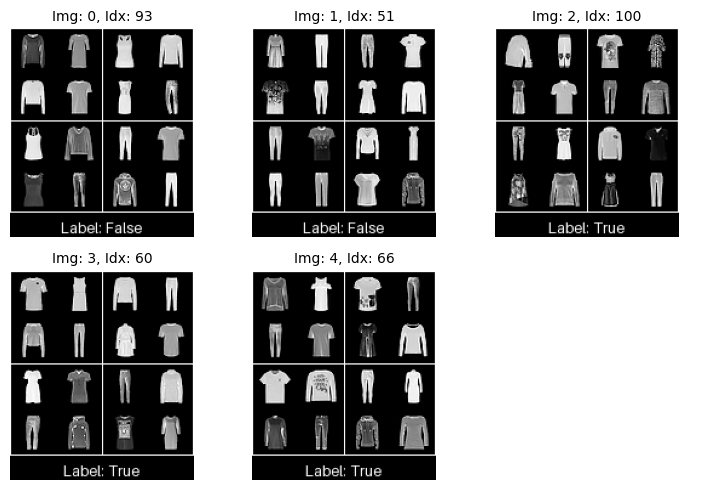

In [ ]:
data_dict:dict[str, dict[str, torch.Tensor]] = torch.load(os.path.join(DATASETS_DIR, 'fmnist_4x4_split_11.pt'))

train_dict = data_dict['train']
train_symbols = train_dict['symbols']
train_digits = train_dict['digits']
train_labels = train_dict['labels']

n_images, board_dim, _, symbol_size, _ = train_symbols.shape
n_blocks = int(board_dim ** 0.5)

vlm_indices = torch.randperm(n_images)[:5]
pil_image_list, base64_image_list = symbols_to_images(vlm_indices, board_dim, symbol_size, train_symbols, train_labels)

n_rows = torch.floor(torch.tensor(vlm_indices.shape[0] ** 0.5)).int().item()
n_cols = torch.ceil(torch.tensor(vlm_indices.shape[0] / n_rows)).int().item()
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
for k, ax in enumerate(axs.flatten()):
    ax.axis('off')
    if k < vlm_indices.shape[0]:
        ax.imshow(pil_image_list[k], cmap='gray')
        ax.set_title(f'Img: {k}, Idx: {vlm_indices[k]}', fontsize=10)
fig.tight_layout()
fig.show()

for n, vlm_index in enumerate(vlm_indices):
    print(f'Idx: {vlm_index}, Lbl: {train_labels[vlm_index].item()}')
    print(test_digits[n, :, :])

In [ ]:
train_symbols.shape

torch.Size([200, 4, 4, 28, 28])